Visualizations and descriptive states
==============

In [111]:
# Create paths to pkl files
import os
project_root = os.path.abspath("..")
reg_path = os.path.join(project_root, "data", "processed", "clean_reg_data.pkl")
auth_path = os.path.join(project_root, "data", "processed", "clean_auth_data.pkl")
ab_path = os.path.join(project_root, "data", "processed", "clean_ab_test.pkl")

In [112]:
# Import library
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [113]:
# Read pkl files
df_reg_data = pd.read_pickle(reg_path)
df_auth_data = pd.read_pickle(auth_path)
df_ab_test = pd.read_pickle(ab_path)

In [114]:
print(df_reg_data.head(5))
print("===========")
print(df_auth_data.head(5))

                     reg_ts  uid
0 1998-11-18 09:43:43+00:00    1
1 1999-07-22 22:38:09+00:00    2
2 2000-01-13 22:27:27+00:00    3
3 2000-05-28 14:19:01+00:00    4
4 2000-09-16 11:21:53+00:00    5
                    auth_ts  uid
0 1998-11-18 09:43:43+00:00    1
1 1999-07-22 22:38:09+00:00    2
2 1999-07-25 16:46:46+00:00    2
3 1999-07-31 03:50:15+00:00    2
4 1999-08-05 17:49:39+00:00    2


When calculating based on date or using functions like groupby, having time in date can mess up with our analysis so let's normalize them by setting all the time to midnight! We don't use dt.date() to avoid changing the datetime type to object.

In [115]:
df_reg_data['reg_ts'] = df_reg_data['reg_ts'].dt.floor('d')
df_auth_data['auth_ts'] = df_auth_data['auth_ts'].dt.floor('d')

At what days after registering do players usually log in?

In [116]:
# Merge the dataframes of registration and login data
df_reg_auth = pd.merge(df_reg_data, df_auth_data, on="uid", how="left")
df_reg_auth.head(5)

,reg_ts,uid,auth_ts
0,1998-11-18 00:00:00+00:00,1,1998-11-18 00:00:00+00:00
1,1999-07-22 00:00:00+00:00,2,1999-07-22 00:00:00+00:00
2,1999-07-22 00:00:00+00:00,2,1999-07-25 00:00:00+00:00
3,1999-07-22 00:00:00+00:00,2,1999-07-31 00:00:00+00:00
4,1999-07-22 00:00:00+00:00,2,1999-08-05 00:00:00+00:00


In [117]:
# How many days is it from players' registration date to the login date
df_reg_auth["elapsed_days"] = (df_reg_auth["auth_ts"] - df_reg_auth["reg_ts"]).dt.days
df_reg_auth.head(5)

,reg_ts,uid,auth_ts,elapsed_days
0,1998-11-18 00:00:00+00:00,1,1998-11-18 00:00:00+00:00,0
1,1999-07-22 00:00:00+00:00,2,1999-07-22 00:00:00+00:00,0
2,1999-07-22 00:00:00+00:00,2,1999-07-25 00:00:00+00:00,3
3,1999-07-22 00:00:00+00:00,2,1999-07-31 00:00:00+00:00,9
4,1999-07-22 00:00:00+00:00,2,1999-08-05 00:00:00+00:00,14


In [118]:
elapsed_days_count = df_reg_auth.groupby(["elapsed_days"])["auth_ts"]

In [119]:
# How many players log in to the game after an amount of days since their registration
elapsed_days_count = df_reg_auth.groupby(["elapsed_days"])["auth_ts"].count().reset_index(name="frequency")
# Let's add a percentage column for the frequency. The denominator should be the number of unique uid.
elapsed_days_count["percentage"] = elapsed_days_count["frequency"] / df_reg_auth["uid"].nunique() * 100
elapsed_days_count

,elapsed_days,frequency,percentage
0,0,1000000,100.0000
1,1,20071,2.0071
2,2,40997,4.0997
3,3,46338,4.6338
4,4,52258,5.2258
...,...,...,...
5911,7716,1,0.0001
5912,7720,1,0.0001
5913,7721,1,0.0001
5914,7727,1,0.0001


To answer the question "At what days after registering do players usually log in?", let's sort the above df

In [120]:
elapsed_days_count.sort_values(by="frequency", ascending=False).head(6)

,elapsed_days,frequency,percentage
0,0,1000000,100.0000
6,6,68194,6.8194
5,5,59863,5.9863
7,7,58140,5.8140
4,4,52258,5.2258
11,11,50814,5.0814


Except for the registration date (where elapsed days equal 0), it's interesting to learn that most players log in around 1 week after registering instead of the day after. 

We also want to find out the players who have logged in the most

In [121]:
df_reg_auth.groupby(["uid"])["auth_ts"].count().reset_index(name="login_days").sort_values(by="login_days", ascending=False).head(10)

,uid,login_days
1,2,1929
99,108,1397
148,158,1367
163,176,1331
175,191,1296
194,212,1294
187,204,1294
255,280,1264
261,287,1256
305,336,1248


The dataset covers more than 20 years since 1998, thus I'm interested to learn about loyal players who logged in to the game even after 10 years (3650 days), and see how many login sessions they have done during the past 10 years.

In [122]:
long_term_players = (df_reg_auth[df_reg_auth["elapsed_days"] > 3650])
long_term_players.groupby(["uid"])["auth_ts"].count().reset_index(name="login_sessions").sort_values(by="login_sessions", ascending=False).head(10)

,uid,login_sessions
0,2,1023
1,108,479
2,158,445
3,176,412
4,191,395
5,204,391
6,212,382
7,224,361
8,280,344
9,287,338


Players who have logged in the most overall are generally those who still play the game even after 10 years. It is common that players tend to play less after 10 years, however player uid=2 have actually played more in the latter 10 years than their first 10 years. 

Let's plot day 1, 7, 30, 90, 365 retention rate! (Daily, weekly, monthly, quarterly, and yearly)!

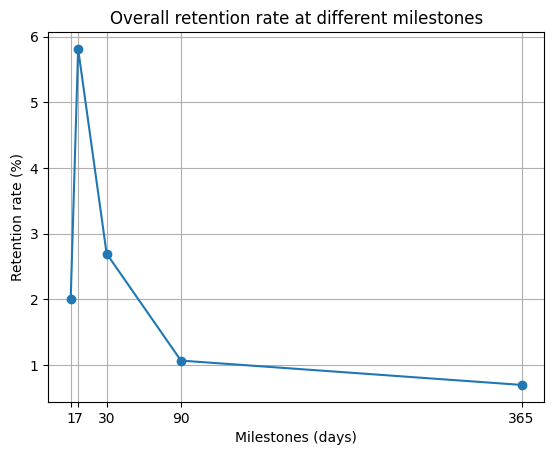

In [123]:
periods = [1, 7, 30, 90, 365]
day_retention = elapsed_days_count[elapsed_days_count["elapsed_days"].isin(periods)]

plt.plot(day_retention["elapsed_days"], day_retention["percentage"], marker='o')
plt.title("Overall retention rate at different milestones")
plt.xlabel('Milestones (days)')
plt.ylabel('Retention rate (%)')
plt.xticks(periods)
plt.grid(True)
plt.show()

The game has quite low retention rates, with day-1 being only 2% and day-7 being close to 6% (a good benchmark for mobile games is around 30% and 20% for day-1 and day-7, respectively). Day-1 retention being so low hints at the game possibly being hard for players to grasp, i.e. their first impression of the game may be poor; however, day-7 retention being higher may suggest a possibility that players do find the game interesting, yet lack the incentive to log in daily.

It should also be noted that the retention rate above does not take into account different registration date. Moreover, it only captures the users returning at the exact milestones, not those who logging in on different days.

Let's calculate day 1, 7, 30, 90, 360 rolling retention rate, i.e. taking account of players returning at least once on or after the milestones. 

In [124]:
periods = [1, 7, 30, 90, 365]
total_players = df_reg_data["uid"].nunique()
rolling_day_retention = {} # Using dict is more straightforward than trying to append to DataFrame

for p in periods:
    returned_players = df_reg_auth[df_reg_auth["elapsed_days"] >= p]["uid"].nunique()
    rolling_day_retention[p] = returned_players / total_players * 100

print(rolling_day_retention)

{1: 23.8378, 7: 21.3281, 30: 10.2106, 90: 4.318099999999999, 365: 2.7468}


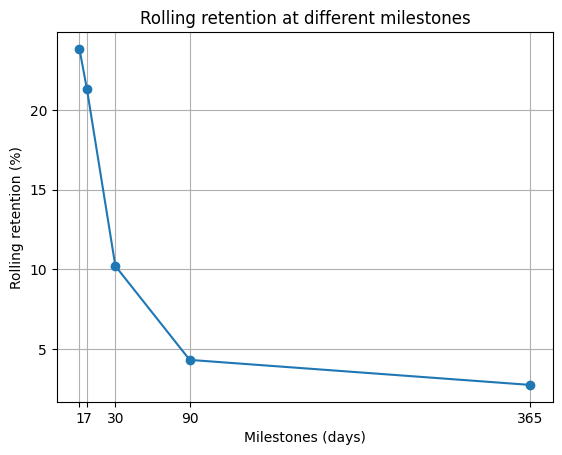

In [125]:
# Plot the rolling rentention rate
rolling_day_retention = rolling_day_retention.items() # Convert dict into key-value pairs
x, y = zip(*rolling_day_retention) # Extract x and y with zip
plt.plot(x, y, marker='o')
plt.title("Rolling retention at different milestones")
plt.xlabel('Milestones (days)')
plt.ylabel('Rolling retention (%)')
plt.xticks(periods)
plt.grid(True)
plt.show()

Except for the abnormal 1-day retention rate, the rolling retention graph looks similar to the normal retention one! 

The rolling retention rate comes in handy below where we calculate the rolling retention rate for consecutive days to notice any change in user engagement overtime.

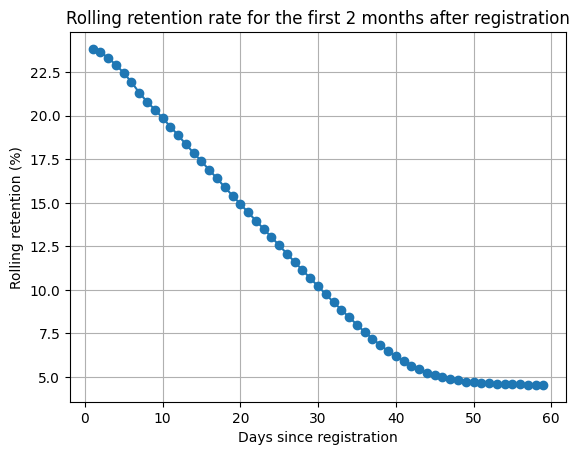

In [126]:
sixty_days = range(1, 60)
total_players_1 = df_reg_data["uid"].nunique()
rolling_day_retention_1 = {} # Using dict is more straightforward than trying to append to DataFrame

for p in sixty_days:
    returned_players = df_reg_auth[df_reg_auth["elapsed_days"] >= p]["uid"].nunique()
    rolling_day_retention_1[p] = returned_players / total_players_1 * 100

rolling_day_retention_1 = rolling_day_retention_1.items() # Convert dict into key-value pairs
x, y = zip(*rolling_day_retention_1) # Extract x and y with zip
plt.plot(x, y, marker='o')
plt.title("Rolling retention rate for the first 2 months after registration")
plt.xlabel('Days since registration')
plt.ylabel('Rolling retention (%)')
plt.grid(True)
plt.show()

The curve starts flattening out at around 50 days after players' registration, so if the game manages to keep players logging in even then, it will likely be able to retain the players after one year. 

It is not uncommon for players' sentiment to differ across different stages/versions of the game, so let's us calculate the daily retention rate for each registration date! 

In [127]:
# First, we count how many players there are for each daily cohort/registration date
daily_cohorts = df_reg_data.groupby(["reg_ts"])["uid"].nunique().reset_index(name="cohort_count")
daily_cohorts

,reg_ts,cohort_count
0,1998-11-18 00:00:00+00:00,1
1,1999-07-22 00:00:00+00:00,1
2,2000-01-13 00:00:00+00:00,1
3,2000-05-28 00:00:00+00:00,1
4,2000-09-16 00:00:00+00:00,1
...,...,...
5105,2020-09-19 00:00:00+00:00,1634
5106,2020-09-20 00:00:00+00:00,1636
5107,2020-09-21 00:00:00+00:00,1638
5108,2020-09-22 00:00:00+00:00,1641


In [128]:
df_cohort_count = df_reg_auth.groupby(["reg_ts", "elapsed_days"])["uid"].nunique().reset_index(name="cohort_count")
df_cohort_count

,reg_ts,elapsed_days,cohort_count
0,1998-11-18 00:00:00+00:00,0,1
1,1999-07-22 00:00:00+00:00,0,1
2,1999-07-22 00:00:00+00:00,3,1
3,1999-07-22 00:00:00+00:00,9,1
4,1999-07-22 00:00:00+00:00,14,1
...,...,...,...
2716223,2020-09-21 00:00:00+00:00,1,31
2716224,2020-09-21 00:00:00+00:00,2,49
2716225,2020-09-22 00:00:00+00:00,0,1641
2716226,2020-09-22 00:00:00+00:00,1,14


In [129]:
# Let's create a dictionary of the key-value pairs: registration day reg_ts and the number of registered players on that day
cohort_sizes = df_cohort_count[df_cohort_count["elapsed_days"] == 0].set_index("reg_ts")["cohort_count"]
cohort_sizes

reg_ts
1998-11-18 00:00:00+00:00       1
1999-07-22 00:00:00+00:00       1
2000-01-13 00:00:00+00:00       1
2000-05-28 00:00:00+00:00       1
2000-09-16 00:00:00+00:00       1
                             ... 
2020-09-19 00:00:00+00:00    1634
2020-09-20 00:00:00+00:00    1636
2020-09-21 00:00:00+00:00    1638
2020-09-22 00:00:00+00:00    1641
2020-09-23 00:00:00+00:00    1048
Name: cohort_count, Length: 5110, dtype: int64

In [130]:
# We calculate the retention rate for each cohort day and elapsed days
df_cohort_count["retention_rate"] = df_cohort_count["cohort_count"] / df_cohort_count["reg_ts"].map(cohort_sizes)
df_cohort_count

,reg_ts,elapsed_days,cohort_count,retention_rate
0,1998-11-18 00:00:00+00:00,0,1,1.000000
1,1999-07-22 00:00:00+00:00,0,1,1.000000
2,1999-07-22 00:00:00+00:00,3,1,1.000000
3,1999-07-22 00:00:00+00:00,9,1,1.000000
4,1999-07-22 00:00:00+00:00,14,1,1.000000
...,...,...,...,...
2716223,2020-09-21 00:00:00+00:00,1,31,0.018926
2716224,2020-09-21 00:00:00+00:00,2,49,0.029915
2716225,2020-09-22 00:00:00+00:00,0,1641,1.000000
2716226,2020-09-22 00:00:00+00:00,1,14,0.008531


In [131]:
# For illustrative purposes, let's filter out only those registering in August 2020, and drop the logins of players on their registration days
df_cohort_count_copy = df_cohort_count
mask1 = (df_cohort_count["reg_ts"] >= "2020-08-01") & (df_cohort_count["reg_ts"] <= "2020-08-31")
mask2 = (df_cohort_count["elapsed_days"] != 0) & (df_cohort_count["elapsed_days"] <= 31)
df_cohort_count_copy = df_cohort_count_copy[mask1 & mask2][["reg_ts", "elapsed_days", "retention_rate"]]
df_cohort_count_copy["reg_ts"] = df_cohort_count_copy["reg_ts"].dt.date
df_cohort_count_copy

,reg_ts,elapsed_days,retention_rate
2714744,2020-08-01,1,0.019244
2714745,2020-08-01,2,0.044459
2714746,2020-08-01,3,0.043132
2714747,2020-08-01,4,0.055740
2714748,2020-08-01,5,0.059058
...,...,...,...
2715947,2020-08-31,19,0.045483
2715948,2020-08-31,20,0.034744
2715949,2020-08-31,21,0.039798
2715950,2020-08-31,22,0.027795


In [132]:
# Let's create a retention_matrix! Non-existing pairs of reg_ts and elapsed_days are replaced with 0.
retention_matrix = pd.pivot(index="reg_ts", columns="elapsed_days", values="retention_rate", data=df_cohort_count_copy)
retention_matrix.fillna(0, inplace=True)  
retention_matrix = round(retention_matrix * 100, 2)
retention_matrix

elapsed_days,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
reg_ts,,,,,,,,,,,,,,,,,,,,,
2020-08-01,1.92,4.45,4.31,5.57,5.91,7.63,6.37,4.51,6.37,4.78,...,4.05,3.78,4.18,4.11,2.52,3.12,3.19,3.05,2.72,2.79
2020-08-02,2.58,4.04,4.37,5.17,6.49,6.63,6.03,4.51,5.30,5.50,...,3.84,3.91,3.98,3.25,3.38,2.98,3.38,3.31,2.65,2.98
2020-08-03,1.72,4.30,4.03,5.56,6.15,7.54,5.29,4.96,4.89,5.36,...,4.37,2.98,3.90,3.17,4.37,3.37,3.24,2.58,2.18,3.51
2020-08-04,2.05,3.57,4.69,5.22,5.28,6.47,5.15,4.43,4.69,5.28,...,3.04,4.43,2.91,3.17,2.97,3.17,2.64,2.71,2.18,2.84
2020-08-05,2.57,3.49,4.02,5.74,5.08,7.78,6.13,4.22,4.75,4.75,...,3.30,3.30,3.76,2.97,3.56,2.77,3.03,3.10,2.77,2.44
2020-08-06,1.71,5.07,5.73,5.60,5.73,7.50,6.06,5.00,5.79,5.13,...,3.88,3.36,3.82,3.09,2.90,4.08,3.16,2.83,2.90,2.11
2020-08-07,2.17,3.09,5.26,5.32,5.98,7.16,6.18,5.12,4.99,4.93,...,3.09,3.81,3.88,3.55,3.94,2.37,3.88,2.96,3.55,3.02
2020-08-08,2.43,4.79,4.20,5.45,5.45,7.22,6.30,3.94,4.79,5.25,...,4.33,3.35,4.00,3.54,2.62,2.76,3.15,2.82,2.23,3.67
2020-08-09,2.10,3.93,4.65,5.37,7.07,6.29,6.61,4.45,4.91,4.45,...,4.13,3.73,4.32,3.14,3.54,3.54,2.88,3.67,2.55,3.27


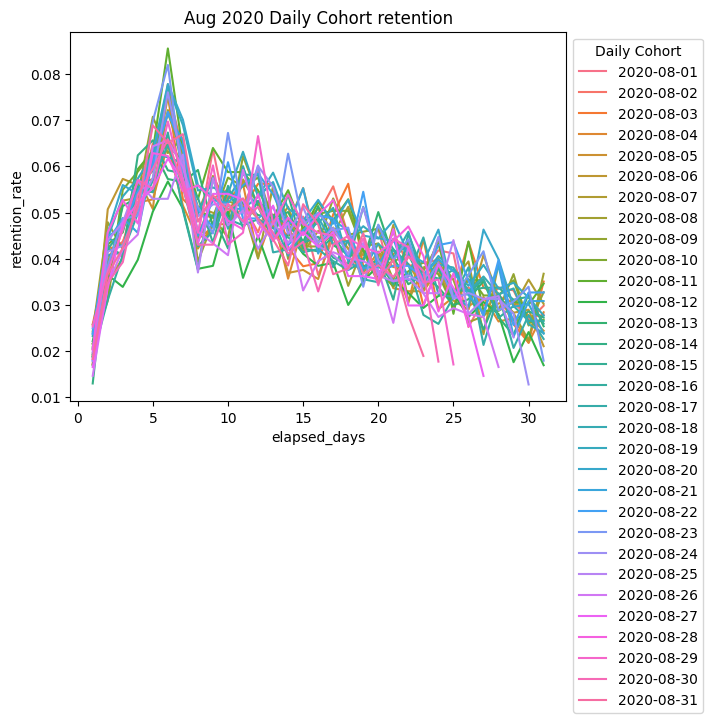

In [133]:
# Plot the rentention rate of each cohort in August 2020
sns.lineplot(
    data=df_cohort_count_copy,
    x="elapsed_days",
    y="retention_rate",
    hue="reg_ts"
)
plt.title("Aug 2020 Daily Cohort retention")
plt.legend(title="Daily Cohort", bbox_to_anchor=(1, 1))
plt.show()